In [20]:
# coding=utf8

import pandas as pd
import numpy as np
from sklearn.svm import SVC
import matplotlib.pyplot as plt

In [21]:
# 加载数据
df0 = pd.read_csv('data/DQC00-1d.txt',
                  sep=',',
                  nrows=5000,
                  index_col=['datetime'],  # 设置行索引
                  parse_dates=['datetime'],  # 解析时间 20100104130500.0
                  date_parser=lambda x: pd.to_datetime(x, format='%Y%m%d%H%M%S.%f'),  # 时间解析的格式，进行毫秒级数据解析
                  usecols=['datetime', 'open', 'high', 'low', 'close', 'volume'],  # 设置需要用到的列
                  encoding='utf-8',
                  float_precision='round_trip',  # 所有数据会当做string读取, 使用时再进行相应的转换为float
                  )
# pd.reset_option('display.float_format')  # 重置
pd.set_option('precision', 2)  # 显示小数点后的位数
pd.set_option('display.max_rows', 300)  # 控制显示的最大行数
pd.set_option('display.min_rows', 20)  # 确定显示的部分有多少行
pd.options.display.float_format = '{:.2f}'.format  # 统一设置小数位数
# pd.set_option('display.float_format',  '{:,.2f}'.format) # 数字格式化显示 用逗号格式化大值数字 设置数字精度
# 指定列名设置计算精确度，未指定的保持原样
df0.round({'open': 0, 'high': 0, 'low': 0, 'close': 0, 'volume': 0})
# 统一设置小数位数
df0.round(0)
#设定numpy显示浮点数精度的小数位数,不使用科学记数法
np.set_printoptions(precision=2, suppress=True)

print(df0.dtypes)
df0.head()

open      float64
high      float64
low       float64
close     float64
volume    float64
dtype: object


,open,high,low,close,volume
datetime,,,,,
2004-09-22,1143.23,1147.88,1106.05,1106.98,77908.00
2004-09-23,1097.68,1099.54,1089.32,1093.04,37196.00
2004-09-24,1082.81,1101.40,1082.81,1095.83,29367.00
2004-09-27,1092.11,1100.47,1075.38,1076.31,17336.00
2004-09-28,1077.24,1088.39,1077.24,1082.81,26681.00


In [22]:
# 2.1 缺失值处理

# 检查数据中是否有缺失值，以下两种方式均可
# #Flase:无缺失值 #True：有缺失值
print('返回每一列缺失值统计个数:', df0.isnull().sum())
df0 = df0.dropna(axis=0, how='any')  #删除包含缺失值的行
print('检查数据中是否有缺失值:', df0.isnull().any())


返回每一列缺失值统计个数: open      0
high      0
low       0
close     0
volume    0
dtype: int64
检查数据中是否有缺失值: open      False
high      False
low       False
close     False
volume    False
dtype: bool


In [23]:
# 截取时间段内样本数据
df = df0["2021-01-01":].copy()
print(df[:3])
# 2.2 确定特征值 目标值
# df.reset_index(level=0, inplace=True)   #时间索引成为列

# 特征值取 开 高 低 收 价
X = df.loc[:, ['open', 'close', 'high', 'low']].values
print(type(X), X.ndim, X.shape)
print(X[:3, ])


              open    high     low   close    volume
datetime                                            
2021-01-04 2664.50 2687.72 2650.96 2655.80 633210.00
2021-01-05 2654.83 2686.75 2654.83 2678.04 472285.00
2021-01-06 2683.85 2706.09 2679.01 2694.49 481959.00
<class 'numpy.ndarray'> 2 (213, 4)
[[2664.5  2655.8  2687.72 2650.96]
 [2654.83 2678.04 2686.75 2654.83]
 [2683.85 2694.49 2706.09 2679.01]]


In [24]:
# 收盘价>开盘价 标记为类别1 收盘价<=开盘价 标记为类别0
# df['flag'] = df.apply(lambda x: 1 if (x['close'] > x['open']) else 0, axis=1)


# 收盘价>开盘价 标记类别为1 收盘价<开盘价 标记类别为-1 收盘价=开盘价 标记类别为0
# epsilon = 0.1  #误差
# df['flag'] = df.apply(
#     lambda x: 0 if (abs(x['close'] - x['open']) <= epsilon)
#     else ( 1 if (x['close'] > x['open']) else -1), axis=1)

# 收盘价-开盘价>1 标记为类别1 收盘价-开盘价<1 标记为类别0
df['flag'] = df.apply(lambda x: 0 if (abs(x['close'] - x['open']) <= 1) else 1, axis=1)
print(df.head(20))
print(df.info())
# 目标值取收盘
Y = df.loc[:, 'flag'].values
print(type(Y), Y.shape, Y.ndim)
print(Y[:5])


              open    high     low   close     volume  flag
datetime                                                   
2021-01-04 2664.50 2687.72 2650.96 2655.80  633210.00     1
2021-01-05 2654.83 2686.75 2654.83 2678.04  472285.00     1
2021-01-06 2683.85 2706.09 2679.01 2694.49  481959.00     1
2021-01-07 2694.49 2718.66 2692.55 2713.83  510463.00     1
2021-01-08 2717.70 2746.71 2710.93 2742.84  630350.00     1
2021-01-11 2748.65 2815.38 2708.99 2743.81 1181606.00     1
2021-01-12 2746.71 2780.56 2714.80 2773.79  802689.00     1
2021-01-13 2777.66 2833.76 2771.86 2777.66  953263.00     0
2021-01-14 2782.50 2790.23 2738.01 2751.55  823129.00     1
2021-01-15 2752.52 2785.40 2748.65 2774.76  597012.00     1
2021-01-18 2780.56 2814.41 2777.66 2786.37  727775.00     1
2021-01-19 2782.50 2801.84 2758.32 2773.79  625718.00     1
2021-01-20 2773.79 2779.60 2738.98 2751.55  636369.00     1
2021-01-21 2753.48 2778.63 2746.71 2755.42  546861.00     1
2021-01-22 2751.55 2766.06 2712.86 2728.

In [25]:
print(type(X), X.shape, X.ndim)
print(type(Y), Y.shape, Y.ndim)

<class 'numpy.ndarray'> (213, 4) 2
<class 'numpy.ndarray'> (213,) 1


In [26]:
# 2.1 缺失值处理

# 检查数据中是否有缺失值，以下两种方式均可
# #Flase:无缺失值 #True：有缺失值
print('返回每一列缺失值统计个数:', df.isnull().sum())
df = df.dropna(axis=0, how='any')  #删除包含缺失值的行
print('检查数据中是否有缺失值:', df.isnull().any())


返回每一列缺失值统计个数: open      0
high      0
low       0
close     0
volume    0
flag      0
dtype: int64
检查数据中是否有缺失值: open      False
high      False
low       False
close     False
volume    False
flag      False
dtype: bool


In [27]:
#将数据划分为训练集和验证集
from sklearn.model_selection import train_test_split

x_train_stand, x_test_stand, y_train, y_test = train_test_split(
    X, Y.reshape(-1, 1),
    random_state=1,  #如果为整形数字,则数据随机打乱顺序固定, 如果为random_state=None,则每次数据打乱顺序都不一样
    test_size=0.50,  #测试集50%样本数量
    shuffle=True,  #default=True 切分前是否对数据进行打乱。
)

In [28]:
## 混淆测试集目标类别的 指定概率50%的错误
# err = y_train
# for i in range(int(len(err) * 0.0)):
#     index = int(np.random.randint(len(err)))
#     err[index] = 0 if err[index] == 1 else 1
# 查看测试集是否与未混淆后不同
# print(np.sum(y_train>0)+np.sum(y_test>0), np.sum(Y>0))


In [29]:
# 3. 特征工程（标准化）
from sklearn.preprocessing import StandardScaler

standardScaler = StandardScaler()

# 训练集 计算平均值和标准偏差
x_train_stand = standardScaler.fit_transform(x_train_stand)
# 以训练集的平均值和标准偏差来缩放测试集
x_test_stand = standardScaler.transform(x_test_stand)

y_train_stand = y_train
y_test_stand = y_test

In [30]:
# 目标类别为0，1 不用标准化
print(y_train[:5])
print(type(x_train_stand), x_train_stand.shape, x_train_stand.ndim)
print(type(y_train), y_train.shape, y_train.ndim)

[[1]
 [1]
 [1]
 [1]
 [1]]
<class 'numpy.ndarray'> (106, 4) 2
<class 'numpy.ndarray'> (106, 1) 2


In [31]:
c = 300
# 拟合分类模型
linear = SVC(kernel='linear', C=c, gamma='scale', probability=True)
rbf = SVC(kernel='rbf', C=c, gamma='scale', probability=True)
poly = SVC(kernel='poly', C=c, gamma='scale', degree=3, coef0=1, probability=True)

kernel = [linear, rbf, poly]
kernel_label = ["linear", "rbf", "poly"]
for ix, svc in enumerate(kernel[:-1]):
    performance = svc.fit(x_train_stand, y_train.ravel())
    # 获取预测值
    y_test_pred = performance.predict(x_test_stand)
    # 显示估计器
    print(ix, svc.kernel, kernel[ix], 'sv:', svc.support_vectors_.shape)
    # 获取这个估计器的参数
    svc_params = svc.get_params()
    print(
        f'估计器的参数: kernel=%s, c=%s, gamma=%s' % (svc_params.get('kernel'), svc_params.get('C'), svc_params.get('gamma')))
    # https://blog.csdn.net/gracejpw/article/details/101546293
    # 返回预测的决定系数R^2
    # R^2越接近于1，模型的拟合优度越高。
    print(f'训练集R2评分: %s ' % (performance.score(x_train_stand, y_train)))
    print(f'测试集R2评分: %s ' % (svc.score(x_test_stand, y_test)))
    print()

0 linear SVC(C=300, kernel='linear', probability=True) sv: (24, 4)
估计器的参数: kernel=linear, c=300, gamma=scale
训练集R2评分: 0.9622641509433962 
测试集R2评分: 0.9345794392523364 

1 rbf SVC(C=300, probability=True) sv: (16, 4)
估计器的参数: kernel=rbf, c=300, gamma=scale
训练集R2评分: 0.9716981132075472 
测试集R2评分: 0.9345794392523364 



0 linear svcs: SVC(C=300, kernel='linear', probability=True)
sv__s: (24, 2) sv__sum: 48 sv_mean: 2670.57 [[2670.73 2672.68 2692.09 2646.78]]
sv__av:55.61 std:98.69 max:2833.76 min:2513.04 sv_av:90.71
训练集评分:0.96
测试集评分:0.93

1 rbf svcs: SVC(C=300, probability=True)
sv__s: (16, 2) sv__sum: 32 sv_mean: 2642.45 [[2643.38 2642.13 2661.72 2622.57]]
sv__av:82.57 std:112.32 max:2833.76 min:2480.00 sv_av:106.74
训练集评分:0.97
测试集评分:0.93



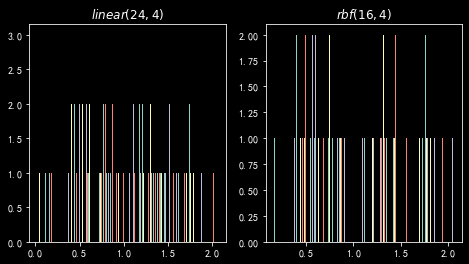

In [32]:

np.round(2)
plt.figure(figsize=(12, 4))
xx = np.vstack((x_train_stand[:, ], x_test_stand[:, ]))
yy = np.vstack((y_train.reshape(-1, 1), y_test.reshape(-1, 1)))
x_min, x_max = xx.min() - 0.5, xx.max() + 0.5
y_min, y_max = yy.min() - 0.5, yy.max() + 0.5

kernel = [linear, rbf, poly]
kernel_label = ["linear", "rbf", "poly"]
for ix, svc in enumerate(kernel[:-1]):
    fit = svc.fit(x_train_stand, y_train.ravel())
    # 获取预测值
    y_test_pred = fit.predict(x_test_stand)
    # 获取这个估计器的参数
    svr_params = svc.get_params()
    print(ix,
          svc.kernel,
          'svcs:', kernel[ix])

    sv_ = fit.support_vectors_  #支持向量
    sv__ = standardScaler.inverse_transform(sv_)
    sv__h = np.hstack((np.amax(abs(sv__), axis=1).reshape(-1, 1),
                       np.amin(abs(sv__), axis=1).reshape(-1, 1)))  #由每一行中最大和最小值的sv构成的新的sv数组
    sv_mean = standardScaler.inverse_transform(np.mean(sv_, axis=0).reshape(1, -1))  #svm平均值

    sv__s = sv__h.shape  #支持向量数组维度
    sv__sum = (sv__s[0] * sv__s[1])  #所有支持向量的数量
    print('sv__s:', sv__s,  #支持向量维度
          'sv__sum: %s' % sv__sum,  #支持向量个数
          'sv_mean: %.2f' % np.mean(sv_mean), sv_mean,   #sv平均值
          )

    sv__mean = np.mean(sv__h)  #sv 均值
    print('sv__av:%.2f' % (sv__mean / sv__sum),  #平均值
          'std:%.2f' % np.std(sv__h),  #标准差
          'max:%.2f' % sv__h.max(),  #svm间隔最大值
          'min:%.2f' % sv__h.min(),  #svm间隔最小值
          'sv_av:%.2f' % (abs(sv__h - sv__mean).sum() / sv__sum),  #sv平均间隔
          )

    # https://blog.csdn.net/gracejpw/article/details/101546293
    # 返回预测的决定系数R^2
    # R^2越接近于1，模型的拟合优度越高。
    print(f'训练集评分:%.2f' % (fit.score(x_train_stand, y_train)))
    print(f'测试集评分:%.2f' % (fit.score(x_test_stand, y_test)))
    print()
    plt.subplot(1, 3, ix + 1)
    interval = abs(sv_)
    plt.hist(interval, bins=50)
    plt.title(r'$%s %s$' % (fit.kernel, sv_.shape))

plt.show()
# plt.savefig(r'./file/svm_svr.png', dpi=200)


In [33]:
# 将标准化后数据，还原成样本数据
x_train_inverse = standardScaler.inverse_transform(x_train_stand)
x_test_inverse = standardScaler.inverse_transform(x_test_stand)

from sklearn.metrics import accuracy_score

# 预测精度得分 normalize=False 返回正确分类样本数
accuracy_score(y_test, y_test_pred, normalize=True)


0.9345794392523364

In [34]:
#设定numpy显示浮点数精度的小数位数,不使用科学记数法
np.set_printoptions(precision=3, suppress=True)

# clf = linear
clf = rbf
score_test = clf.score(x_test_stand, y_test)
print(clf.kernel)

print(clf.predict(x_test_stand)[:3])
print(y_test[:3])

rbf
[1 1 1]
[[1]
 [0]
 [1]]


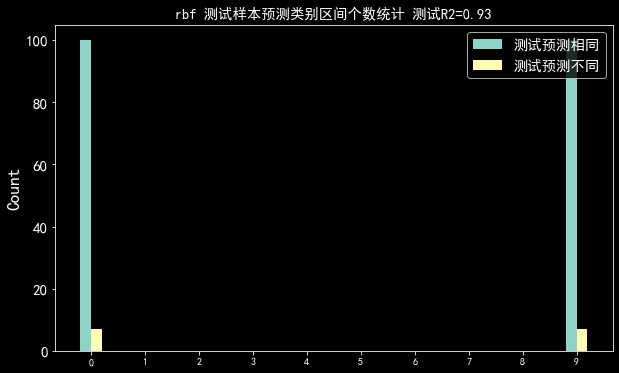

In [35]:
# 绘制训练样本类别预测与目标分类的相同和不同的概率区别统计图
plt.style.use(plt.style.available[4])  #可以通过下标进行选择适合自己的样式
plt.rcParams['font.sans-serif'] = ['SimHei']  #指定默认字体,用来正常显示中文标签
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.unicode_minus'] = False  #用来正常显示负号

id_test_no = clf.predict(x_test_stand)[:] != y_test.ravel()  #测试样本预测类别与测试目标类别不同的下标
id_test_ok = clf.predict(x_test_stand)[:] == y_test.ravel()  #测试样本预测类别与测试目标类别不同的下标
test_no = clf.predict_proba(x_test_stand)[id_test_no]  #测试样本预测类别与测试目标类别不同的概率值
test_ok = clf.predict_proba(x_test_stand)[id_test_ok]

# 绘制测试样本类别预测与目标分类的相同和不同的概率区别统计图
his_test_ok, _ = np.histogram(test_ok, bins=10)
his_test_no, _ = np.histogram(test_no, bins=10)
# 绘制图像
fig, ax1 = plt.subplots()
fig.set_size_inches(10, 6)
# plt.set_cmap('RdBu')
plt.set_cmap('jet')
x = np.arange(len(_) - 1)
w = 0.1
# 绘制多个bar在同一个图中, 这里需要控制width
plt.bar(x - 1 * w, height=his_test_ok, width=2 * w, align='center')  #测试样本预测相同
plt.bar(x + 1 * w, height=his_test_no, width=2 * w, align='center')  #测试样本预测不同
# 设置坐标轴的标签
ax1.yaxis.set_tick_params(labelsize=15)  # 设置y轴的字体的大小
ax1.set_xticks(x)  # 设置xticks出现的位置
# 设置坐标轴名称
ax1.set_ylabel("Count", fontsize='xx-large')
# 设置标题
ax1.set_title('%s 测试样本预测类别区间个数统计 测试R2=%.2f' % (clf.kernel, score_test), fontsize='x-large')
# 设置图例
plt.legend(('测试预测相同', '测试预测不同'), fontsize='x-large', loc='upper right')
plt.show()

In [36]:
print(y_train[:10].ravel())
print(y_test[:10].ravel())
print(x_train_stand.shape, x_test_stand.shape)
print(y_train.shape, y_train.ndim)
print(x_test_stand[:5])
print(y_test_pred[:50].ravel())

[1 1 1 1 1 1 1 1 1 1]
[1 0 1 1 1 1 1 1 1 1]
(106, 4) (107, 4)
(106, 1) 2
[[ 0.23   0.233  0.238  0.414]
 [-0.504 -0.506 -0.448 -0.327]
 [ 0.97   0.359  0.759  0.5  ]
 [ 0.378  0.212  0.309  0.414]
 [ 0.218  0.139  0.032  0.296]]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
